In [1]:
import numpy as np
import pandas as pd
import os
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
import torch

%matplotlib inline

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import json

def savef(obj, name):
    with open(f'{name}.json', 'w') as ouf:
        json.dump(obj, ouf, sort_keys=True)
        
def loadf(name):
    with open(f'{name}.json', 'r') as inf:
        fromfile = json.load(inf)
    return fromfile

In [4]:
def metric(y_true, y_pred):
    l2ratio = np.sum((y_true - y_pred)**2) / np.sum(y_true**2)
    return np.sqrt(l2ratio) * 100


In [5]:
NUM_CHANNELS = 58
SAMPLE_SIZE = 1000
STRIDE = SAMPLE_SIZE
BATCH_SIZE = 32

### Load data

In [6]:
def load_data(train_eeg_dir="/home/maxrasskazov/data/train/"):
    global train_eeg_names
    train_eeg_names = [x for x in sorted(os.listdir(train_eeg_dir)) 
                     if x[-3:] == ".h5"]
    data = []

    for i, eeg_name in enumerate(train_eeg_names):
    #     print(i, eeg_name)
        try:
            h5_file = h5py.File(train_eeg_dir + eeg_name, 'r')
            a_group_key = list(h5_file.keys())[0]
            eeg_data = np.array(h5_file[a_group_key]).T
            data.append(eeg_data)
        except FileNotFoundError:
            print("can't find {}".format(eeg_name))
    return data

In [7]:
def find_bad_channels(file_data):
    ''' finds bad (zero or noised) channels in a file '''
    n_channels = file_data.shape[1]
    bad_channels = []
    for ch in range(n_channels):
        std = file_data[:, ch].std()
        if (
            std < 1e-10 or std > 1e-4
        ):
            bad_channels.append(ch)
    return bad_channels

### split to inner test and train

Разобьем так: в тренировочный сет - все хорошие ээг, без нулевых или аномальных каналов, в тестовый - все остальные. Кроме того, сделаем так, чтобы в тренировочном и тестовом были ээг разных людей. Итого 14 файлов в тренировочном, 18 в тестовом.

# model training

In [8]:
from copy import deepcopy

def divide_data(data):
    ''' devides data into train and test in some manner'''
    test_files = [1, 8, 9, 10, 13, 19, 20, 22, 25, 27, 28, 29, 0, 2, 5, 14, 30, 31] # , 3, 21, 7, 12, 14, 18, 26
    data_test = [file for i, file in enumerate(data) if i in test_files]
    data_train = [file for i, file in enumerate(data) if i not in test_files]
    return data_train, data_test

# data = load_data()
# data_train, data_test = divide_data(data)

zero channels in data

In [9]:
def find_all_bad_channels(data):
    all_bad_channels = []
    # f = open('./bad_channels.txt', 'w')
    for i, file_data in enumerate(data):
        bad = find_bad_channels(file_data)
        all_bad_channels.append(bad)
    return all_bad_channels

#### clip and scale data

In [10]:
def scale_clip(data_train, data_test, scaling_factor=1000):
    ''' scales both training and test set by scaling factor
    # (and probably clips a training set)'''
    
    for i in range(len(data_train)):
        data_train[i] *= scaling_factor
#         np.clip(data_train[i], a_min=-1, a_max=1, out=data_train[i])
    for i in range(len(data_test)):
        data_test[i] *= scaling_factor

transformation for learning

In [11]:
from random import randrange, sample, seed

def split_val_train(data, test_size=0.1):
    '''returns a list of pairs of indices of beginning and end of
    validation segments in each file'''
    seed(42)  # stable
    margin = 2**10
    val_segments = []
    for file in data:
        test_length = int(file.shape[0] * test_size)
        start = randrange(margin, file.shape[0] - margin - test_length)
        val_segments.append((start, start + test_length))
    return val_segments


In [12]:
from random import sample, seed, shuffle
# seed(42)
sample_inds, parameters = [], (0, 0, 0, 0)
inds_gen = 0

def make_samples_list(data, val_segments, sample_size, stride):
    ''' makes a list start and finish indices of training samples'''
    global sample_inds, parameters
    t = []
    for i, (val_start, val_end) in enumerate(val_segments):
        length = data[i].shape[0]
        t.extend([(i, beg) for beg in range(0, val_start - sample_size, stride)])
        t.extend([(i, beg) for beg in range(val_end, length - sample_size, stride)])
#     shuffle(t)
    sample_inds, parameters = t, (id(data), id(val_segments), sample_size, stride)

def gen_batches(data, val_segments, sample_size, stride=None, batch_size=BATCH_SIZE):
    '''generates batches of samples'''
    global inds_gen
    if stride is None:
        stride = sample_size
    if parameters != (id(data), id(val_segments), sample_size, stride):
        make_samples_list(data, val_segments, sample_size, stride)
    perm = sample(sample_inds, k=len(sample_inds))
    for i in range(0, len(perm), batch_size):
        batch_inds = perm[i: i + batch_size]
        short = batch_size - len(batch_inds)
        if short:
            batch_inds.extend(sample(perm, k=short))
        samples = []
        for (file_ind, start_ind) in batch_inds:
            samples.append(data[file_ind][start_ind: start_ind + sample_size].reshape(1, sample_size, NUM_CHANNELS))
        batch = np.concatenate(samples, axis=0)
        yield batch

# allegedly the latter is trsh
    
# def batch_inds_gen(batch_size):
#     for i in range(0, len(sample_inds), batch_size):
#         yield sample_inds[i: i + batch_size]

# def make_batch(data, val_segments, sample_size, stride=None, batch_size=BATCH_SIZE):
#     global inds_gen
#     if stride is None:
#         stride = sample_size
        
#     if parameters != (id(data), id(val_segments), sample_size, stride):
#         make_samples_list(data, val_segments, sample_size, stride)

#     try:
#         batch_inds = next(inds_gen)
#     except:
#         shuffle(sample_inds)
#         inds_gen = batch_inds_gen(batch_size)
#         batch_inds = next(inds_gen)

#     short = batch_size - len(batch_inds)
#     if short:
#         print('epoch ends')
#         batch_inds.extend([sample(sample_inds, k=short)])
#     samples = []
#     for (file_ind, start_ind) in batch_inds:
#         samples.append(data[file_ind][start_ind: start_ind + sample_size].reshape(1, sample_size, NUM_CHANNELS))
#     batch = np.concatenate(samples, axis=0)
#     return batch

In [13]:
def make_val_set(data, val_segments, sample_size, stride=None):
    ''' name doesn't lie'''
    if stride is None:
        stride = sample_size
    
    samples = []
    for i, (val_start, val_end) in enumerate(val_segments):
        for start_ind in range(val_start, val_end - sample_size, stride):
            samples.append(data[i][start_ind: start_ind + sample_size].reshape(1, sample_size, NUM_CHANNELS))
    return np.concatenate(samples, axis=0)

In [14]:
def compute_loss(batch, restored_batch, file_inds, all_bad_channels, cuda=True):
    '''computes mse loss if there are bad channels'''
    loss = 0
    losses = []
    for i, file_ind in enumerate(file_inds):
        orig = batch[i,:,:]
        restored = restored_batch[i,:,:]
        if all_bad_channels[file_ind]:
            good_ch = [x for x in range(NUM_CHANNELS) if x not in all_bad_channels[file_ind]]
            if cuda:
                good_ch = Variable(torch.cuda.LongTensor(good_ch))
            else:
                good_ch = Variable(torch.LongTensor(good_ch))
            orig = torch.index_select(orig, dim=1, index=good_ch)
            restored = torch.index_select(restored, dim=1, index=good_ch)
        losses.append(F.mse_loss(restored, orig))
    overall = sum(losses) / len(losses)
    return overall

In [15]:
import time
from IPython.display import clear_output

def train_autoencoder(model, data, val_segments,
                      optimizer=None, loss_history=[[], []], sample_size=32,
                      batch_size=32, max_epoch=500, min_epoch=6, cuda=True,
                      clip=None, make_opt=False, stop_point=0.99,
                      ch_drop_pr=None):
    '''monsterous function that does training'''
    
    def model_repr():
        return model.repr() + f'{"_dr" if ch_drop_pr else ""}'
    
    if cuda:
        model.cuda()
    else:
        model.cpu()
        
    if make_opt or not optimizer:
        optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)

    test_set = make_val_set(data, val_segments, sample_size)
    variance = test_set.var(axis=(0,1)).mean()
    if cuda:
        test_set = Variable(torch.cuda.FloatTensor(test_set), volatile=True)
    else:
        test_set = Variable(torch.FloatTensor(test_set), volatile=True)
    
    mod_name = model.__repr__()[:model.__repr__().find('(')]
    
    min_test_loss = float('inf')
    
    grad_norms = []
    
    for epoch in range(max_epoch):
        start_time = time.time()
        model.train(True)
        for batch in gen_batches(data, val_segments, sample_size, batch_size=batch_size):
            if cuda:
                batch = Variable(torch.cuda.FloatTensor(batch))
            else:
                batch = Variable(torch.FloatTensor(batch))

            if ch_drop_pr is not None:
                m = nn.Dropout2d(p=ch_drop_pr)
                batch = torch.transpose(m(torch.transpose(batch, 1, 2)), 1, 2) # modeling channel death
                batch = batch * (1 - ch_drop_pr) # compensating for dropout layer scaling

            restored_batch = model(batch)

            # compute loss
            loss = F.mse_loss(restored_batch, batch)
            #loss = compute_loss(batch, restored_batch, file_inds, cuda=cuda)  
            # train with backprop
            loss.backward()

            if clip:
                clip_norm = clip * np.median(grad_norms[-300:]) if  grad_norms else 1
                norm = torch.nn.utils.clip_grad_norm(model.parameters(), clip_norm)
                grad_norms.append(norm)

            optimizer.step()

            optimizer.zero_grad()


            loss_history[0].append(loss.data[0])

        model.train(False)
        loss_test = F.mse_loss(model(test_set), test_set).data[0]
        #loss_test = compute_loss(test_set, model(test_set), test_inds, cuda=cuda).data[0]
        loss_history[1].append(loss_test)

        # update best model so far
        if loss_test < min_test_loss:
            torch.save(model, model_repr() + '_curbest.pt')
            min_test_loss = loss_test


        stop = False                
        if (len(loss_history[1]) > min_epoch # epoch
            and np.median(loss_history[1][-(min_epoch ):]) /
                np.median(loss_history[1][-2 * min_epoch:-(min_epoch )]) > stop_point):
            stop = True # to stop ineffective learning

        clear_output(True)

        print(model_repr())
        
        if epoch == 0:
            epoch_len = len(loss_history[0]) // len(loss_history[1])
            test_history_plot = []
            for i, h in enumerate(loss_history[1]):
                beg = loss_history[1][i - 1] if i > 0 else loss_history[0][0]
                test_history_plot.extend([beg + (h - beg) * j / epoch_len
                                          for j in range(1, epoch_len + 1)])
        else:
            test_history_plot.extend([loss_history[1][-2] +
                                      (loss_history[1][-1] - loss_history[1][-2]) * j / epoch_len
                                      for j in range(1, epoch_len + 1)])            
        plt.figure(figsize=(10,7))
        plt.plot(loss_history[0],label='train loss')
        plt.plot(test_history_plot,label='test loss')
        plt.yscale('log')
        plt.legend()
        if stop:
            plt.savefig('./' + model_repr() + '.png', format='png')
        plt.show()


        plt.plot(loss_history[0][-2*epoch_len:], label='loss')
        plt.legend()
        plt.show()

        print('train loss =     ', loss.data[0])
        print('test loss =      ', loss_test)
        print('min test loss =', min_test_loss)
        print('test variance =  ', variance)
        print("Epoch {}  took {:.3f}s for {} iterations".format(
        epoch + 1, time.time() - start_time, epoch_len))

        if stop:
            break
    if clip:
        savef(grad_norms, 'grad_norms_' + model_repr())
#     torch.save(model, model_repr() + f'_{len(loss_history[0])}it.pt')
    savef(loss_history, 'history_' + model_repr() + f'_{len(loss_history[0])}it')
    del batch, test_set
    torch.cuda.empty_cache()


In [16]:
from pickle import dump, load


In [17]:
def rsqr(y_true, y_pred):
    return 1 - np.mean((y_true - y_pred)**2) / np.var(y_true)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [18]:
def predict(model, data_test, file_ind, sample_size):
    file_data = data_test[file_ind]
    file_data = file_data[:file_data.shape[0] // sample_size * sample_size]
    orig_shape = file_data.shape
    set1 = file_data.reshape(-1, sample_size, orig_shape[-1])
    if cuda:
        set1 = Variable(torch.cuda.FloatTensor(set1), volatile=True)
        model.cuda()
    else:
        set1 = Variable(torch.FloatTensor(set1), volatile=True)
        model.cpu()
    pred1 = model(set1).cpu().data.numpy().reshape(orig_shape)
    del set1  #, set2
    torch.cuda.empty_cache()
    return pred1 #+ pred2
    
    

In [19]:
def find_metric_on_file(autoencoder, data_test, file_ind, sample_size, all_bad_channels):
    file = data_test[file_ind]
    file = file[:file.shape[0] // sample_size * sample_size]
    bad = all_bad_channels[file_ind]
    predicted = predict(autoencoder, data_test, file_ind, sample_size)
    alive_pred = np.delete(predicted, bad, axis=1)
    alive_true = np.delete(file, bad, axis=1)
    return metric(alive_true, alive_pred), rsqr(alive_true, alive_pred), mse(alive_true, alive_pred)

# CNN

In [25]:
class Eeg_CNN_AE(nn.Module):
    def __init__(self, sample_size=108, conv1_kernel=9, conv1_layers=25,
                 lin1=100, compressed=108, dropout=0, batchnorm=False): # 108, 9, 100,  
        super(self.__class__, self).__init__()
        (self.sample_size, self.conv1_kernel, self.conv1_layers, self.lin1, self.dropout,
         self.batchnorm) = (sample_size,
                            conv1_kernel, conv1_layers, lin1, dropout, batchnorm)
        self.dropout_e1 = nn.Dropout(p=dropout)
        self.conv_e1 = nn.Conv2d(in_channels=1,
                                 out_channels=conv1_layers,
                                 kernel_size=(conv1_kernel, 1))
        self.linear_e1 = nn.Linear(conv1_layers * 58, lin1)
        self.batchnorm_e1 = nn.BatchNorm2d(num_features=1)
        self.maxpool_e1 = nn.MaxPool2d(kernel_size=(4,1))
        self.linear_e2 = nn.Linear((sample_size - conv1_kernel + 1) // 4 * lin1, compressed)
        
        self.linear_d1 = nn.Linear(compressed, (sample_size - conv1_kernel + 1) // 4 * lin1)
        self.upsample_d1 = nn.Upsample(size=(sample_size - conv1_kernel + 1, lin1), mode='bilinear') # scale_factor=(4,1)
        self.linear_d2 = nn.Linear(lin1, conv1_layers * 58)
        self.dropout_d1 = nn.Dropout(p=dropout)
        self.conv_d1 = nn.ConvTranspose2d(in_channels=conv1_layers,
                                 out_channels=1,
                                 kernel_size=(conv1_kernel, 1))
        self.batchnorm_d1 = nn.BatchNorm2d(num_features=1)
        self.linear_out = nn.Linear(58, 58)
        
    def repr(self):
        mod_name = model.__repr__()[:model.__repr__().find('(')]
        return f'{mod_name}_{self.sample_size}s_{model.conv_e1.kernel_size}c1k_\
{model.conv_e1.out_channels}c1l_{model.linear_e1.out_features}l1_{model.dropout}d\
{"_b" if model.batchnorm else ""}'
        
    def forward(self, x):
        assert (isinstance(x, Variable)
                and (isinstance(x.data, torch.FloatTensor)
                     or isinstance(x.data, torch.cuda.FloatTensor)))
#         print(x.shape)
        x = torch.unsqueeze(x, 1) #x.view(x.shape[0], -1, *x.shape[1:])   # [b, 1, 108, 58]
        if self.dropout:
            x = self.dropout_e1(x)
        x = self.conv_e1(x)  # [b, 25, 100, 58]
#         print(x.shape)
        x = x.permute(0, 2, 1, 3)  # [b, 100, 25, 58]
#         print(x.shape)
        x = x.contiguous().view(x.size(0) ,x.size(1), -1)
#         print(x.shape)
        x = torch.unsqueeze(x, 1)  # [b, 1, 100, 25 * 58]
#         print(x.shape)
        x = self.linear_e1(x)  # [b, 1, 100, 100]
#         print(x.shape)
        if self.batchnorm:
            x = self.batchnorm_e1(x)
        x = F.elu(x)
        x = self.maxpool_e1(x)  # [b, 1, 25, 100]
        x = x.view(x.shape[0], -1) # [b, 25 * 100]
#         print(x.shape, repr(self.linear_e2))
        x = self.linear_e2(x)
        #bottleneck
        x = self.linear_d1(x) # [b, 25 * 100]
        x = x.view(x.shape[0], 1, -1, self.lin1)  # [b, 1, 25, 100]
        x = self.upsample_d1(x)  # [b, 1, 100, 100]
        x = self.linear_d2(x)  # [b, 1, 100, 25 * 58]
        x = x.view(x.shape[0], x.shape[2], -1, 58)  # [b, 100, 25, 58]
        x = x.permute(0, 2, 1, 3).contiguous()   #torch.transpose(x, 1, 2)  # [b, 25, 100, 58]
        if self.dropout:
            x = self.dropout_d1(x)
#         x = x.clone()
        x = self.conv_d1(x)  # [b, 1, 108, 58]
        if self.batchnorm:
            x = self.batchnorm_d1(x)
        x = F.elu(x)
        x = self.linear_out(x)
        x = torch.squeeze(x, dim=1) # (x.shape[0], *x.shape[2:])
        return x



In [26]:
data = load_data()
data_train, data_test = divide_data(data)
scale_clip(data_train, data_test, scaling_factor=1000)
val_segments = split_val_train(data_train)

In [ ]:
# pd.DataFrame(columns=['sample_size', 'rnn_units', 'alpha', 'val_loss'])
# cnn_df = pd.DataFrame(columns=['sample_size', 'kernel', 'layers', 'dropout', 'batchnorm', 'alpha', 'val_loss'])
cnn_df = pd.read_csv('cnn.csv')

for kernel in [9, 17]: # 9,
    for ss_mult in [1, 2, 4]: # 2,
        for layers in [8,  32]: # 8, , 64 , 16
            for d, b in [(0,False), (0, True)]: #24 , (0.1, True)
                ss = (4 * ss_mult - 1 + kernel)
                lin1 = 58 * layers // 8
                comp = ss_mult * lin1 // 2
                try:
                    model = torch.load(f'Eeg_CNN_AE_{ss}s_({kernel}, 1)c1k_{layers}c1l_{lin1}l1_{d}d\
{"_b" if b else ""}_dr_curbest.pt')
                    history_file = [x for x in os.listdir('./')
                                    if x.startswith(f'history_Eeg_CNN_AE_{ss}s_({kernel}, 1)c1k_{layers}c1l_{lin1}l1_{d}d\
{"_b" if b else ""}_dr') and x[-5:] == ".json"][0][:-5]
                    history = loadf(history_file)
                except (FileNotFoundError, IndexError):
                    model = Eeg_CNN_AE(sample_size=ss, conv1_kernel=kernel, conv1_layers=layers,
                                         lin1=lin1, compressed=comp, dropout=d, batchnorm=b)
                    history = [[], []]
                    
                try:
                    model.train(True)

                    opt = torch.optim.Adam(model.parameters())

                    train_autoencoder(model, data_train, val_segments,
                                      optimizer=opt, loss_history=history, sample_size=ss,
                                      batch_size=BATCH_SIZE, max_epoch=40,
                                      stop_point=0.97,
                                      ch_drop_pr=0.005)

                    model = torch.load(f'Eeg_CNN_AE_{ss}s_({kernel}, 1)c1k_{layers}c1l_{lin1}l1_{d}d\
{"_b" if b else ""}_dr_curbest.pt')
                    model.cuda()
                    model.train(False)
                    val_set = make_val_set(data_train, val_segments, ss)
                    val_set = Variable(torch.cuda.FloatTensor(val_set), volatile=True)
                    loss_val = F.mse_loss(model(val_set), val_set).data[0]
                    cnn_df.loc[len(cnn_df)] = (ss, kernel, layers, d, b, comp/(ss*NUM_CHANNELS), loss_val)

                    del model, val_set
                    torch.cuda.empty_cache()
                except Exception as e:
                    raise e
                    print(model.repr(), '\n', e, file=open('train_errors.txt', 'a'))
# cnn_df.to_csv('cnn.csv', index=False)

In [33]:
# cnn_df.to_csv('cnn.csv', index=False)
cnn_df #.sort_values('val_loss')

,sample_size,kernel,layers,dropout,batchnorm,alpha,val_loss
0,12,9,8,0.0,False,0.041667,7.527122e-06
1,12,9,16,0.0,False,0.083333,3.088303e-06
2,12,9,32,0.0,False,0.166667,1.752670e-06
3,16,9,8,0.0,False,0.062500,4.335933e-06
4,16,9,8,0.5,True,0.062500,8.891375e-06
5,16,9,8,0.1,True,0.062500,4.529052e-06
6,16,9,16,0.0,False,0.125000,1.632450e-06
7,16,9,16,0.5,True,0.125000,1.267186e-05
8,16,9,16,0.1,True,0.125000,2.077848e-06
9,16,9,32,0.0,False,0.250000,1.270937e-06


In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('val_loss ~ sample_size + kernel + layers + dropout + batchnorm + alpha', data=cnn_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               val_loss   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     9.882
Date:                Thu, 14 Jun 2018   Prob (F-statistic):           3.94e-07
Time:                        13:08:54   Log-Likelihood:                 640.32
No. Observations:                  56   AIC:                            -1267.
Df Residuals:                      49   BIC:                            -1252.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.857e-06   1.83e-06      2.661      0.011    1.19e-06    8.53e-06
batchnorm[T.True] -2.507e-06   9.95e-07     -2.519      0.015   -4.51e-06   -5.07e-07
sample_size       -3.927e-07    1.2e-07     -3.270      0.002   -6.34e-07   -1.51e-07
kernel             6.913e-07    1.9e-07      3.644      0.001     3.1e-07    1.07e-06
layers            -2.731e-07   9.88e-08     -2.765      0.008   -4.72e-07   -7.46e-08
dropout            1.411e-05   2.37e-06      5.943      0.000    9.34e-06    1.89e-05
alpha              3.533e-05   1.19e-05      2.974      0.005    1.15e-05    5.92e-05
==============================================================================
Omnibus:                       27.960   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.646
Skew:                           1.624   Prob(JB):                     6.10e-12
Kurtosis:                       6.403   Cond. No.                     1.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
model = Eeg_CNN_AE(sample_size=ss, conv1_kernel=kernel, conv1_layers=layers,
                         lin1=lin1, compressed=comp, dropout=d, batchnorm=b)
print(model.repr())
model.cuda()
val_set = make_val_set(data_train, val_segments, ss)
val_set = Variable(torch.cuda.FloatTensor(val_set), volatile=True)
loss_val = F.mse_loss(model(val_set), val_set).data[0]
loss_val

Eeg_CNN_AE_1000s_(9, 1)c1k_16c1l_116l1_0d


0.0067506153136491776

In [22]:
data = load_data()
data_train, data_test = divide_data(data)

all_bad_channels_train = find_all_bad_channels(data_train)
all_bad_channels_test = find_all_bad_channels(data_test)
scale_clip(data_train, data_test, scaling_factor=1000)


In [31]:
cuda = True
train_metrics, test_metrics = {}, {}
# pd.DataFrame(columns=['sample_size', 'rnn_units', 'alpha', 'val_loss'])
# cnn_df = pd.DataFrame(columns=['sample_size', 'kernel', 'layers', 'dropout', 'batchnorm', 'alpha', 'val_loss'])
# cnn_df = pd.read_csv('cnn.csv')

for kernel in [5, 9]: # 9,
    for ss_mult in [4]: # 2,
        for layers in [8, 16, 32]: # 8, , 64 , 16
            for d, b in [(0, True), (0.1, True)]: #24 
                ss = (4 * ss_mult - 1 + kernel)
                lin1 = 58 * layers // 8
                comp = ss_mult * lin1 // 2
                alpha = comp/(ss*NUM_CHANNELS)
                try:
                    autoencoder = torch.load(f'Eeg_CNN_AE_{ss}s_({kernel}, 1)c1k_{layers}c1l_{lin1}l1_{d}d\
{"_b" if b else ""}_dr_curbest.pt')
                    autoencoder.train(False)
                except (FileNotFoundError, IndexError):
                    print((f'Eeg_CNN_AE_{ss}s_({kernel}, 1)c1k_{layers}c1l_{lin1}l1_{d}d\
{"_b" if b else ""}_dr_curbest.pt was not found'))
                    continue

                print(f'evaluating model with {layers} layers, {kernel} kernel {d}drop and for {ss} length sample')

                metrics_for_cur_model = []
                for i, file in enumerate(data_train):
                    print(f'    evaluating train file {i} ...', end='')
                    metric_file = find_metric_on_file(autoencoder, data_train, i, ss, all_bad_channels_train)
                    metrics_for_cur_model.append(metric_file)
                    print('done')
                train_metrics[(kernel, ss, layers, d, b, alpha)] = metrics_for_cur_model

                metrics_for_cur_model = []
                for i, file in enumerate(data_test):
                    print(f'    evaluating test file {i} ...', end='')
                    metric_file = find_metric_on_file(autoencoder, data_test, i, ss, all_bad_channels_test)
                    metrics_for_cur_model.append(metric_file)
                    print('done')
                test_metrics[(kernel, ss, layers, d, b, alpha)] = metrics_for_cur_model


evaluating model with 8 layers, 5 kernel 0drop and for 20 length sample
    evaluating train file 0 ...torch.Size([31695, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 1 ...torch.Size([30160, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 2 ...torch.Size([30210, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 3 ...torch.Size([30142, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 4 ...torch.Size([30780, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 5 ...torch.Size([31502, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 6 ...torch.Size([30190, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 7 ...torch.Size([32187, 232]) Linear(in_features=232, out_features=116)
done
    evaluating train file 8 ...torch.Size([31262, 232]) Linear(in_features=232, out_features=116)
done
 

In [32]:
dump(train_metrics, open('cnn_inner_train14_metrics.dat', 'wb'))

In [34]:
dump(test_metrics, open('cnn_inner_test14_metrics.dat', 'wb'))

In [34]:
train_metrics = load(open('cnn_inner_train14_metrics.dat', 'rb'))
{key:np.mean([z[0] for z in x]) for key, x in train_metrics.items()}

{(5, 20, 8, 0, True, 0.1): 13.657505289292382,
 (5, 20, 8, 0.1, True, 0.1): 15.793022207276838,
 (5, 20, 16, 0, True, 0.2): 8.1192097682292736,
 (5, 20, 16, 0.1, True, 0.2): 12.558893083274626,
 (5, 20, 32, 0, True, 0.4): 7.7259070986162746,
 (5, 20, 32, 0.1, True, 0.4): 12.281185968374729,
 (9, 24, 8, 0.1, True, 0.08333333333333333): 16.930783252787499,
 (9, 24, 16, 0.1, True, 0.16666666666666666): 12.423318144292931,
 (9, 24, 32, 0.1, True, 0.3333333333333333): 12.202859740112899}

In [35]:
test_metrics = load(open('cnn_inner_test14_metrics.dat', 'rb'))
{key:np.mean([z[0] for z in x]) for key, x in test_metrics.items()}

{(5, 20, 8, 0, True, 0.1): 25.917222585399358,
 (5, 20, 8, 0.1, True, 0.1): 27.928127925274332,
 (5, 20, 16, 0, True, 0.2): 18.887401259571782,
 (5, 20, 16, 0.1, True, 0.2): 24.760983561070734,
 (5, 20, 32, 0, True, 0.4): 18.078724292126441,
 (5, 20, 32, 0.1, True, 0.4): 24.424301084024254,
 (9, 24, 8, 0.1, True, 0.08333333333333333): 29.626938786621736,
 (9, 24, 16, 0.1, True, 0.16666666666666666): 24.705879097862073,
 (9, 24, 32, 0.1, True, 0.3333333333333333): 25.057355902238605}

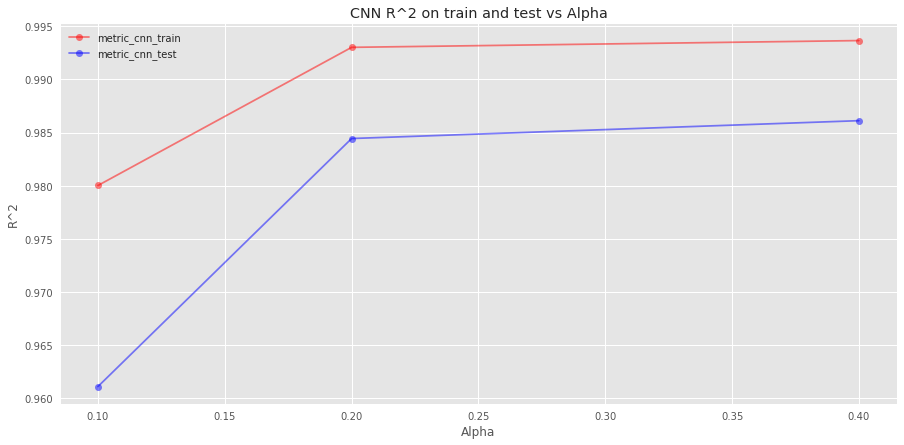

In [47]:
plt.style.use('ggplot')
x2 = [key[-1] for key in train_metrics if key[0] == 5 and key[3] == 0]
plt.figure(figsize=(15, 7))

y2 = [np.mean([z[1] for z in x]) for k,x in train_metrics.items() if k[0] == 5 and k[3] == 0]
plt.plot(x2, y2,  marker='o', alpha = 0.5, label = "metric_cnn_train",  color='r')

y4 = [np.mean([z[1] for z in [m for i,m in enumerate(x) if i not in [12,14,15]]]) for k,x in test_metrics.items() if k[0] == 5 and k[3] == 0]
# [np.mean(x) for x in test_metrics]
plt.plot(x2, y4,  marker='o', alpha = 0.5, label = "metric_cnn_test",  color='b')

plt.title("CNN R^2 on train and test vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("R^2")
plt.legend(loc = 'best')
plt.show()

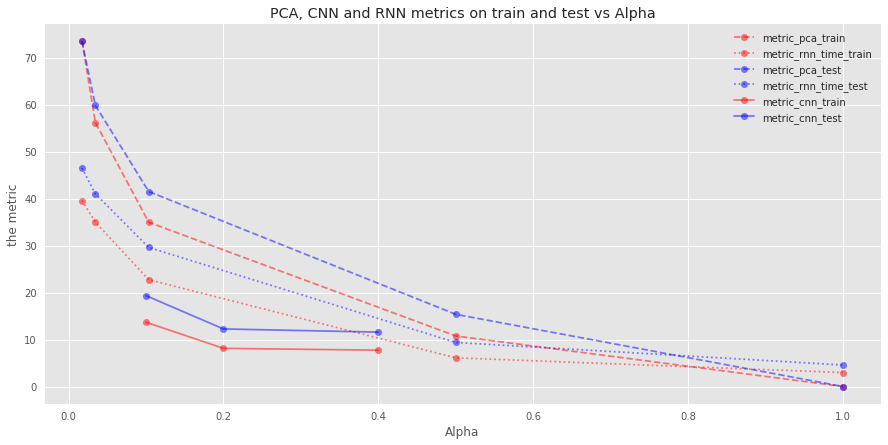

In [46]:
test_metrics_rnn = load(open('../rnn/lstm_time_inner_test14_metrics.dat', 'rb'))
train_metrics_rnn = load(open('../rnn/lstm_time_inner_train14_metrics.dat', 'rb'))


# components_count = [1, 2, 6, 12, 19, 29, 58]
l2_ratio = loadf('../l2_ratio_pca_inner_train14_set')
pca_test_metrics = loadf('../l2_ratio_pca_inner_test_n-14_set')
pca_train = [x[0] for x in l2_ratio] # not quite the same way we measure metric in the other cases but still close
pca_test = [np.mean([m for i,m in enumerate(x) if i not in [12,14,15]]) for x in pca_test_metrics]

train_metrics_rnn = sorted([(hidden * 2 / (sample * NUM_CHANNELS), v) for (sample, hidden), v in train_metrics_rnn.items() if (sample, hidden) in [(64,32), (16,16), (16,48), (8,116), (4,116)]])
test_metrics_rnn = sorted([(hidden * 2 / (sample * NUM_CHANNELS), v) for (sample, hidden), v in test_metrics_rnn.items() if (sample, hidden) in [(64,32), (16,16), (16,48), (8,116), (4,116)]])


plt.style.use('ggplot')
# x1 = np.array(components_count) / 58
x1 = x2 = [x[0] for x in train_metrics_rnn] #[hidden * 2 / (sample * NUM_CHANNELS) for (sample, hidden) in train_metrics[0]]
plt.figure(figsize=(15, 7))
train_metrics_rnn = [x[1] for x in train_metrics_rnn]
test_metrics_rnn = [x[1] for x in test_metrics_rnn]

y1 = [x for i, x in enumerate(pca_train) if i!=3 and i!=4]
plt.plot(x1, y1,  marker='o', alpha = 0.5, label = "metric_pca_train", color='r', ls='dashed')
y2 = [np.mean([z[0] for z in x]) for x in train_metrics_rnn]
plt.plot(x2, y2,  marker='o', alpha = 0.5, label = "metric_rnn_time_train",  color='r', ls='dotted')
y3 = [x for i, x in enumerate(pca_test) if i!=3 and i!=4]
plt.plot(x1, y3,  marker='o', alpha = 0.5, label = "metric_pca_test", color='b', ls='dashed')
y4 = [np.mean([z[0] for z in [m for i,m in enumerate(x) if i not in [12,14,15]]]) for x in test_metrics_rnn]
# [np.mean(x) for x in test_metrics]
plt.plot(x2, y4,  marker='o', alpha = 0.5, label = "metric_rnn_time_test",  color='b', ls='dotted')

train_metrics = load(open('cnn_inner_train14_metrics.dat', 'rb'))
test_metrics = load(open('cnn_inner_test14_metrics.dat', 'rb'))

x3 = [key[-1] for key in train_metrics if key[0] == 5 and key[3] == 0]

y6 = [np.mean([z[0] for z in x]) for k,x in train_metrics.items() if k[0] == 5 and k[3] == 0]
plt.plot(x3, y6,  marker='o', alpha = 0.5, label = "metric_cnn_train",  color='r')
y7 = [np.mean([z[0] for z in [m for i,m in enumerate(x) if i not in [12,14,15]]]) for k,x in test_metrics1.items() if k[0] == 5 and k[3] == 0]
# [np.mean(x) for x in test_metrics]
plt.plot(x3, y7,  marker='o', alpha = 0.5, label = "metric_cnn_test",  color='b')

plt.title("PCA, CNN and RNN metrics on train and test vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("the metric")
plt.legend(loc = 'best')
plt.show()